# Expore data

## Import & definitions

In [109]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 12*6 # 6 hours used to predict next values in future
FUTURE_TARGET = 15 # number of 5 min to predict  : 12 + 3
STEP = 1
BATCH_SIZE = 32

path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

In [110]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [111]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        plt.savefig(os.path.join(saveFolder, f"output_{title}.jpg")) 
    plt.show()

## Load raw features

In [112]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35417,1683156300000,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00,29086.08,29107.93,29043.70,29043.70,76.97644,2023-05-03 23:25:00,326.2,326.5,325.7,325.9,1605.372,2023-05-03 23:25:00
35418,1683156600000,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00,29043.70,29074.56,29025.00,29029.98,171.08664,2023-05-03 23:30:00,325.9,326.4,325.8,325.8,1800.158,2023-05-03 23:30:00
35419,1683156900000,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00,29029.98,29051.82,28984.41,28990.80,259.24123,2023-05-03 23:35:00,325.9,326.1,325.6,325.6,1155.657,2023-05-03 23:35:00
35420,1683157200000,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00,28990.56,29022.13,28945.39,28946.24,230.84357,2023-05-03 23:40:00,325.7,325.8,325.4,325.6,1477.636,2023-05-03 23:40:00


In [113]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
Series([], dtype: int64)

on 35422 samples


### drop nan

In [114]:
df_feat = df_feat_raw.copy()

In [115]:
nb_missing = get_missing(df_feat)

missing data : 
Series([], dtype: int64)

on 35422 samples


In [116]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35417,1683156300000,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00,29086.08,29107.93,29043.70,29043.70,76.97644,2023-05-03 23:25:00,326.2,326.5,325.7,325.9,1605.372,2023-05-03 23:25:00
35418,1683156600000,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00,29043.70,29074.56,29025.00,29029.98,171.08664,2023-05-03 23:30:00,325.9,326.4,325.8,325.8,1800.158,2023-05-03 23:30:00
35419,1683156900000,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00,29029.98,29051.82,28984.41,28990.80,259.24123,2023-05-03 23:35:00,325.9,326.1,325.6,325.6,1155.657,2023-05-03 23:35:00
35420,1683157200000,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00,28990.56,29022.13,28945.39,28946.24,230.84357,2023-05-03 23:40:00,325.7,325.8,325.4,325.6,1477.636,2023-05-03 23:40:00


## Features Selection

### Propotional to the Price

In [117]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'Open_BNB',
 'High_BNB',
 'Low_BNB',
 'Close_BNB',
 'Volume_BNB',
 'date_BNB']

In [118]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH', 'High_ETH', 'Low_ETH', 'Close_ETH', 'Volume_ETH', 'date_ETH']

In [119]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH
0,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...
35417,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00
35418,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00
35419,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00
35420,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00


In [120]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [121]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC', 'High_BTC', 'Low_BTC', 'Close_BTC', 'Volume_BTC', 'date_BTC']

In [122]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [123]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [124]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [125]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Time',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'date_BNB',
 'date_BTC',
 'date_ETH'}

In [126]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [127]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  15


In [128]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Open_BNB',
 'High_BNB',
 'Low_BNB',
 'Close_BNB',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH']

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [129]:
df_feat.shape[0]

35422

In [130]:
TRAIN_SPLIT = round(0.99 * df_feat.shape[0])
TRAIN_SPLIT

35068

In [131]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35417,1683156300000,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00,29086.08,29107.93,29043.70,29043.70,76.97644,2023-05-03 23:25:00,326.2,326.5,325.7,325.9,1605.372,2023-05-03 23:25:00,False
35418,1683156600000,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00,29043.70,29074.56,29025.00,29029.98,171.08664,2023-05-03 23:30:00,325.9,326.4,325.8,325.8,1800.158,2023-05-03 23:30:00,False
35419,1683156900000,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00,29029.98,29051.82,28984.41,28990.80,259.24123,2023-05-03 23:35:00,325.9,326.1,325.6,325.6,1155.657,2023-05-03 23:35:00,False
35420,1683157200000,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00,28990.56,29022.13,28945.39,28946.24,230.84357,2023-05-03 23:40:00,325.7,325.8,325.4,325.6,1477.636,2023-05-03 23:40:00,False


In [132]:
df_feat[df_feat["train"] == True]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35064,1683050400000,1860.78,1861.34,1857.26,1859.79,996.2590,2023-05-02 18:00:00,28583.53,28596.52,28537.19,28583.54,154.70340,2023-05-02 18:00:00,325.3,325.3,324.8,324.9,693.126,2023-05-02 18:00:00,True
35065,1683050700000,1859.80,1864.83,1859.36,1864.83,954.0200,2023-05-02 18:05:00,28583.53,28679.00,28583.53,28678.99,197.70454,2023-05-02 18:05:00,324.9,325.5,324.9,325.5,580.096,2023-05-02 18:05:00,True
35066,1683051000000,1864.83,1867.52,1861.11,1861.36,1703.1838,2023-05-02 18:10:00,28679.00,28711.65,28602.79,28609.26,326.99337,2023-05-02 18:10:00,325.5,325.7,325.2,325.3,1038.841,2023-05-02 18:10:00,True
35067,1683051300000,1861.35,1862.71,1859.78,1861.56,798.7622,2023-05-02 18:15:00,28609.27,28631.11,28573.89,28605.78,167.54133,2023-05-02 18:15:00,325.3,325.4,324.8,325.0,1424.481,2023-05-02 18:15:00,True


In [133]:
df_feat[df_feat["train"] == False]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB,train
35069,1683051900000,1859.54,1862.76,1859.54,1862.35,886.9493,2023-05-02 18:25:00,28563.29,28600.00,28563.29,28596.31,89.83196,2023-05-02 18:25:00,325.0,325.2,325.0,325.1,448.640,2023-05-02 18:25:00,False
35070,1683052200000,1862.34,1863.04,1860.87,1861.37,689.8331,2023-05-02 18:30:00,28596.31,28606.00,28568.20,28575.75,132.51179,2023-05-02 18:30:00,325.1,325.1,324.8,324.9,1001.793,2023-05-02 18:30:00,False
35071,1683052500000,1861.36,1876.31,1861.36,1871.01,8248.5071,2023-05-02 18:35:00,28575.75,28757.29,28575.74,28684.42,509.82968,2023-05-02 18:35:00,324.9,325.9,324.8,325.6,2112.501,2023-05-02 18:35:00,False
35072,1683052800000,1871.02,1871.02,1867.17,1869.21,1683.0060,2023-05-02 18:40:00,28684.42,28688.49,28641.53,28676.56,147.67030,2023-05-02 18:40:00,325.6,325.6,325.4,325.5,964.153,2023-05-02 18:40:00,False
35073,1683053100000,1869.21,1873.98,1868.28,1871.69,1445.3392,2023-05-02 18:45:00,28676.55,28811.98,28666.22,28744.82,386.45060,2023-05-02 18:45:00,325.6,326.0,325.4,325.9,1491.815,2023-05-02 18:45:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35417,1683156300000,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00,29086.08,29107.93,29043.70,29043.70,76.97644,2023-05-03 23:25:00,326.2,326.5,325.7,325.9,1605.372,2023-05-03 23:25:00,False
35418,1683156600000,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00,29043.70,29074.56,29025.00,29029.98,171.08664,2023-05-03 23:30:00,325.9,326.4,325.8,325.8,1800.158,2023-05-03 23:30:00,False
35419,1683156900000,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00,29029.98,29051.82,28984.41,28990.80,259.24123,2023-05-03 23:35:00,325.9,326.1,325.6,325.6,1155.657,2023-05-03 23:35:00,False
35420,1683157200000,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00,28990.56,29022.13,28945.39,28946.24,230.84357,2023-05-03 23:40:00,325.7,325.8,325.4,325.6,1477.636,2023-05-03 23:40:00,False


In [134]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [135]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [136]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [137]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(34982, 72, 15) (34982, 15)
(266, 72, 15) (266, 15)


In [138]:
X_train

array([[[1.00149011e+00, 1.00133106e+00, 1.00149011e+00, ...,
         4.40108000e+02, 4.86609030e+02, 3.34559200e+02],
        [1.00070320e+00, 1.00148174e+00, 1.00179986e+00, ...,
         9.69720000e+01, 3.91190430e+02, 6.82387600e+02],
        [1.00000837e+00, 1.00070320e+00, 1.00106317e+00, ...,
         2.42254000e+02, 2.94738890e+02, 2.28938700e+02],
        ...,
        [9.99832572e-01, 9.99623286e-01, 9.99840943e-01, ...,
         1.05736100e+03, 2.89084600e+02, 6.84592000e+01],
        [9.99773972e-01, 9.99840943e-01, 9.99874429e-01, ...,
         2.37980200e+03, 2.12611280e+02, 1.49791800e+02],
        [1.00000000e+00, 9.99782343e-01, 1.00010883e+00, ...,
         9.09461000e+02, 4.97810970e+02, 3.02095300e+02]],

       [[1.00024266e+00, 1.00102084e+00, 1.00133881e+00, ...,
         9.69720000e+01, 3.91190430e+02, 6.82387600e+02],
        [9.99548151e-01, 1.00024266e+00, 1.00060247e+00, ...,
         2.42254000e+02, 2.94738890e+02, 2.28938700e+02],
        [1.00074471e+00, 

In [139]:
seq_y

array([1.00205301, 1.00030176, 0.99977907, 0.99919712, 1.00054424,
       0.99997306, 1.00228472, 1.00131479, 1.00250026, 1.00246254,
       1.00267269, 1.00214462, 1.00486041, 1.00299061, 1.00309838])

In [140]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00018332, 1.00060387, 1.00265813, ..., 1.00327818, 1.00274979,
        1.00546722],
       [1.00042048, 1.00247435, 1.00072236, ..., 1.002566  , 1.00528293,
        1.00341234],
       [1.00205301, 1.00030176, 0.99977907, ..., 1.00486041, 1.00299061,
        1.00309838]])

In [141]:
seq_y

array([1.00205301, 1.00030176, 0.99977907, 0.99919712, 1.00054424,
       0.99997306, 1.00228472, 1.00131479, 1.00250026, 1.00246254,
       1.00267269, 1.00214462, 1.00486041, 1.00299061, 1.00309838])

In [142]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00018332, 1.00060387, 1.00265813, ..., 1.00327818, 1.00274979,
        1.00546722],
       [1.00042048, 1.00247435, 1.00072236, ..., 1.002566  , 1.00528293,
        1.00341234],
       [1.00205301, 1.00030176, 0.99977907, ..., 1.00486041, 1.00299061,
        1.00309838]])

In [143]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [144]:
X_train.shape

(34982, 72, 15)

In [145]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(34982, 72, 15) (34982, 15)
(266, 72, 15) (266, 15)


## Standardization

In [61]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [62]:
#scaler_y = StandardScaler()
#y_train_sca = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
#y_test_sca = scaler_y.transform(y_test.reshape(-1,y_test.shape[-1])).reshape(y_test.shape)

scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [63]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00311862, 1.0049887 , 1.00302673, ..., 1.00329157, 1.00485358,
        1.00467522],
       [1.00186427, 0.9999084 , 1.00152483, ..., 1.00172957, 1.00155177,
        1.00273714],
       [0.99804777, 0.99966118, 0.99764979, ..., 0.99968807, 1.00087124,
        0.99926859]])

In [64]:
np.mean(y_train_sca)

-2.5527267181100426e-14

In [65]:
np.std(y_train_sca)

1.0

### Check unscaling

In [66]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,Volume_BTC,Volume_ETH
0,1196.32,1196.13,1196.32,1195.65,16541.77,16544.76,16527.51,16535.38,246.3,246.4,245.9,246.2,440.108,486.60903,334.5592
1,1195.38,1196.31,1196.69,1194.90,16534.91,16540.43,16522.55,16526.67,246.2,246.2,246.0,246.1,96.972,391.19043,682.3876
2,1194.55,1195.38,1195.81,1194.55,16526.67,16530.87,16520.00,16520.69,246.1,246.1,246.0,246.0,242.254,294.73889,228.9387
3,1195.98,1194.55,1195.98,1194.31,16521.26,16537.73,16517.72,16534.94,246.0,246.2,245.8,246.2,369.308,481.18777,601.8903
4,1196.06,1195.98,1196.37,1195.97,16534.94,16540.66,16532.33,16535.54,246.2,246.5,246.1,246.4,149.299,309.53189,144.8048
5,1196.61,1196.06,1196.70,1196.06,16535.54,16545.70,16534.62,16544.19,246.3,246.7,246.3,246.7,128.811,311.90922,394.9124
6,1194.36,1196.62,1196.62,1193.72,16544.19,16544.61,16522.03,16527.83,246.7,246.7,246.3,246.4,238.930,394.57703,497.8406
7,1194.22,1194.37,1194.43,1192.72,16527.27,16530.09,16508.39,16524.04,246.4,246.5,246.1,246.2,757.007,612.13471,1299.5971
8,1193.64,1194.22,1194.22,1193.02,16524.83,16525.25,16512.70,16515.43,246.3,246.3,245.8,245.8,172.160,358.94459,409.5032
9,1194.64,1193.64,1195.06,1193.63,16515.91,16535.66,16515.43,16529.16,245.8,246.0,245.5,245.9,1125.032,357.27214,521.0221


In [67]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [68]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [69]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [70]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
X test         :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [71]:
X_train_sca.shape

(34944, 72, 15)

In [72]:
X_train_sca[:,-1,:].shape

(34944, 15)

In [73]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.07254187],
       [-0.03923744],
       [-0.18240999],
       ...,
       [ 0.62716223],
       [ 0.36544886],
       [-0.43085029]])

In [74]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(34944, 16)

In [75]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Open_BNB',
 'High_BNB',
 'Low_BNB',
 'Close_BNB',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH']

In [ ]:
list_col_select

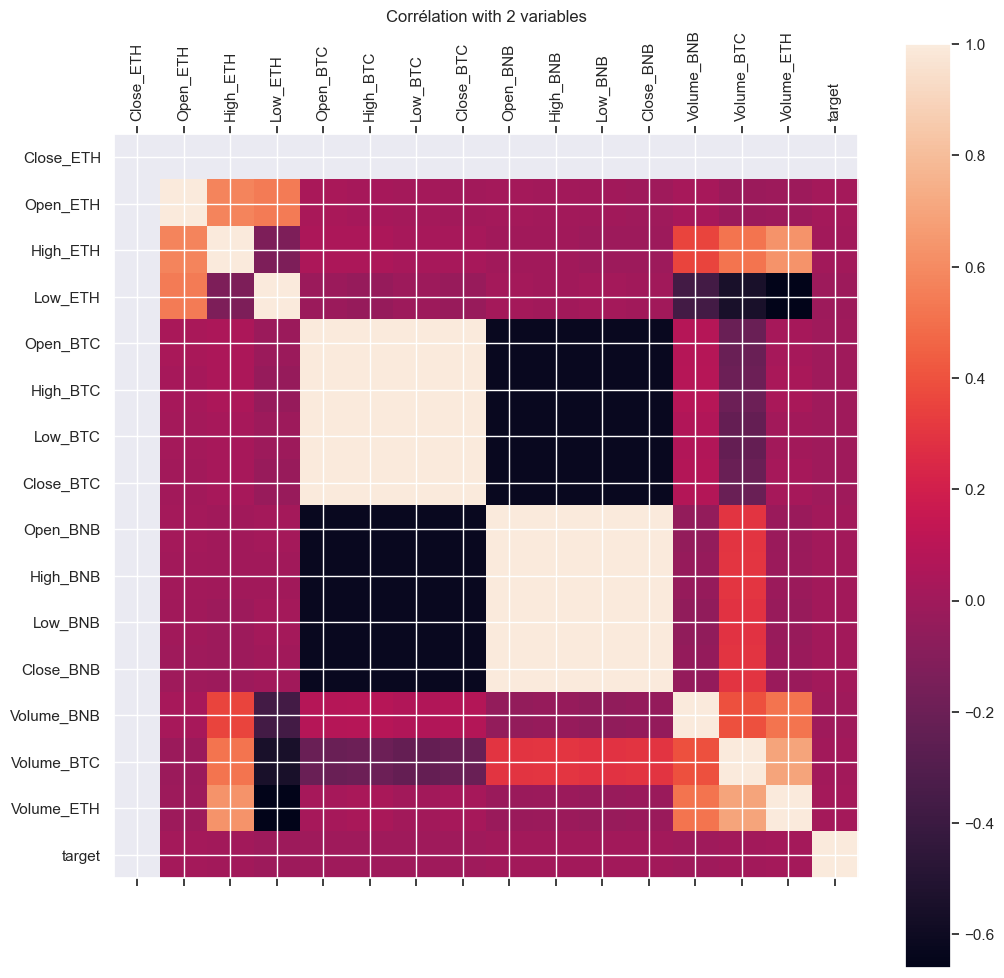

In [77]:

nb_plot = len(list_col_select)
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
    columns=list_col_select[:nb_plot] + ['target'])

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()


In [56]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [1.00142417, 0.99706231, 1.00031834, ..., 1.0056464 , 1.00726605,
        1.00787481],
       [0.99564434, 0.99889575, 1.01323429, ..., 1.00583357, 1.00644147,
        1.00621281],
       [1.00326563, 1.01766689, 1.00134434, ..., 1.01084436, 1.0106147 ,
        1.00696257]])

In [57]:
y_train_sca

array([[ 0.42041552,  0.01449481, -0.19086981, ...,  2.35364795,
         2.61210684,  2.50371439],
       [-0.40897607, -0.61237372, -0.38694959, ...,  2.16375616,
         2.05640189,  1.58471777],
       [-0.21220829,  0.01528545,  0.05313433, ...,  2.48106935,
         2.00505471,  2.19389855],
       ...,
       [ 0.05599307, -0.13676483,  0.00712487, ...,  0.24258074,
         0.31415538,  0.34105757],
       [-0.19942702, -0.05574195,  0.57790181, ...,  0.25085192,
         0.27771585,  0.26761107],
       [ 0.1373704 ,  0.77378617,  0.05246546, ...,  0.47228699,
         0.462138  ,  0.30074435]])

## Autoencoder

In [58]:
X_train.shape

(15219, 48, 104)

### Model creation

In [60]:
df_feat

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,4367,1.625180e+12,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,4367.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,4368,1.625184e+12,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,4368.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,4369,1.625188e+12,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,4369.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,4370,1.625191e+12,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,4370.0,2189.4400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,4371,1.625195e+12,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,4371.0,2192.3925,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15428,19795,1.680721e+12,1900.13,1918.00,1892.88,1909.19,26496.41630,2023-04-05 19:00:00,19795.0,1843.0300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15429,19796,1.680725e+12,1909.18,1915.36,1903.00,1905.75,14370.63690,2023-04-05 20:00:00,19796.0,1845.0550,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15430,19797,1.680728e+12,1905.74,1911.42,1905.74,1911.32,6258.60600,2023-04-05 21:00:00,19797.0,1845.5225,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15431,19798,1.680732e+12,1911.33,1913.69,1907.14,1909.95,9919.22790,2023-04-05 22:00:00,19798.0,1851.0100,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


### Training

Training: units 128 - enc_dim 16 - drop 0.05 ...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 16)          2064      
                                                                 
Total params: 121,360
Trainable params: 121,360
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
__________________________________

2023-04-06 08:08:23.520401: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


476/476 [==============================] - 22s 41ms/step - loss: 0.2132 - val_loss: 0.1005
Epoch 2/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0720 - val_loss: 0.0816
Epoch 3/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0505 - val_loss: 0.0696
Epoch 4/100
476/476 [==============================] - 18s 39ms/step - loss: 0.0389 - val_loss: 0.0585
Epoch 5/100
476/476 [==============================] - 19s 40ms/step - loss: 0.0336 - val_loss: 0.0541
Epoch 6/100
476/476 [==============================] - 19s 40ms/step - loss: 0.0310 - val_loss: 0.0544
Epoch 7/100
476/476 [==============================] - 20s 43ms/step - loss: 0.0283 - val_loss: 0.0513
Epoch 8/100
476/476 [==============================] - 19s 39ms/step - loss: 0.0267 - val_loss: 0.0503
Epoch 9/100
476/476 [==============================] - 18s 39ms/step - loss: 0.0265 - val_loss: 0.0502
Epoch 10/100
476/476 [==============================] - 19s 40ms/step - loss: 0.0241 

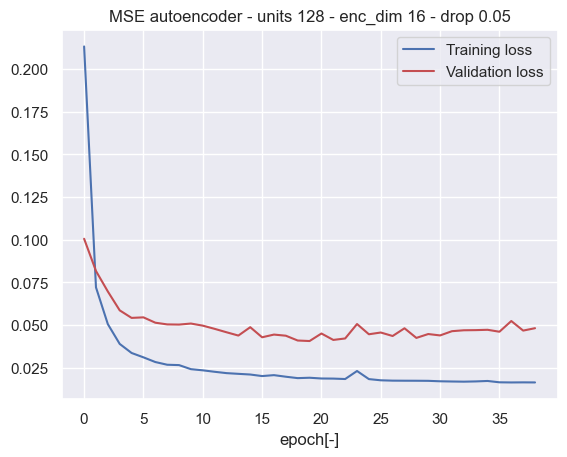

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


In [62]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 100 #150 #6 #300
patience = 20 #40 #3 #100
for n_unit_enc in [128]:
    for encoding_dim in [16]:
        for dropout_autoenc in [0.05]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            path_jpg = os.path.join(path_data, 
                f"output_MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}.jpg")
            if os.path.exists(path_jpg):
                continue
            print(f"Training: units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}",
                saveFolder="data")
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")


### Save model

In [ ]:
# TODO select best model


In [63]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [64]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

476/476 [==============================] - 9s 17ms/step


(15219, 48, 104)

### Results

In [65]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

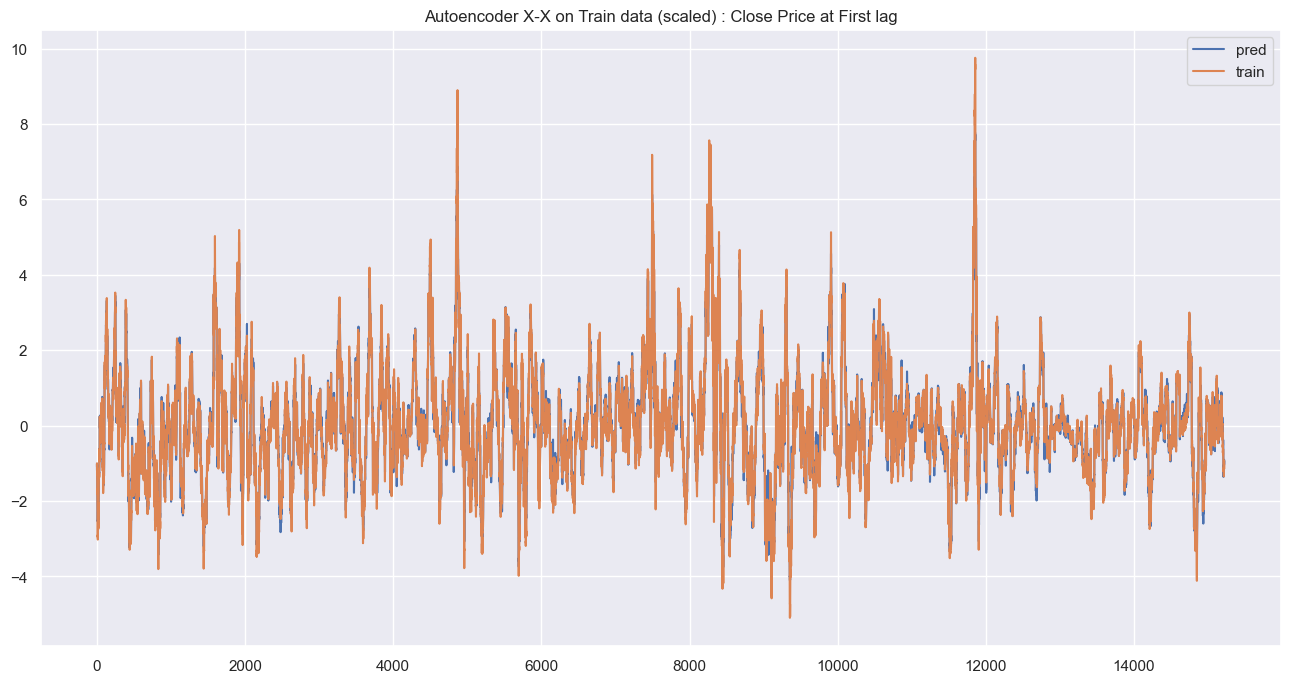

In [66]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [67]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(15219,)
(15219,)
[2106.41 2135.18 2087.34 ... 1715.22 1707.56 1717.02]
[2106.41 2135.18 2087.34]


In [68]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99364364, 0.9924593 , 1.0029678 , ..., 1.0006056 , 1.001886  ,
       1.0066836 ], dtype=float32)

[2106.41 2135.18 2087.34 ... 1715.22 1707.56 1717.02]
[2113.2865393  2117.57394897 2112.69639089 ... 1721.73319904 1716.88501086
 1718.5536192 ]


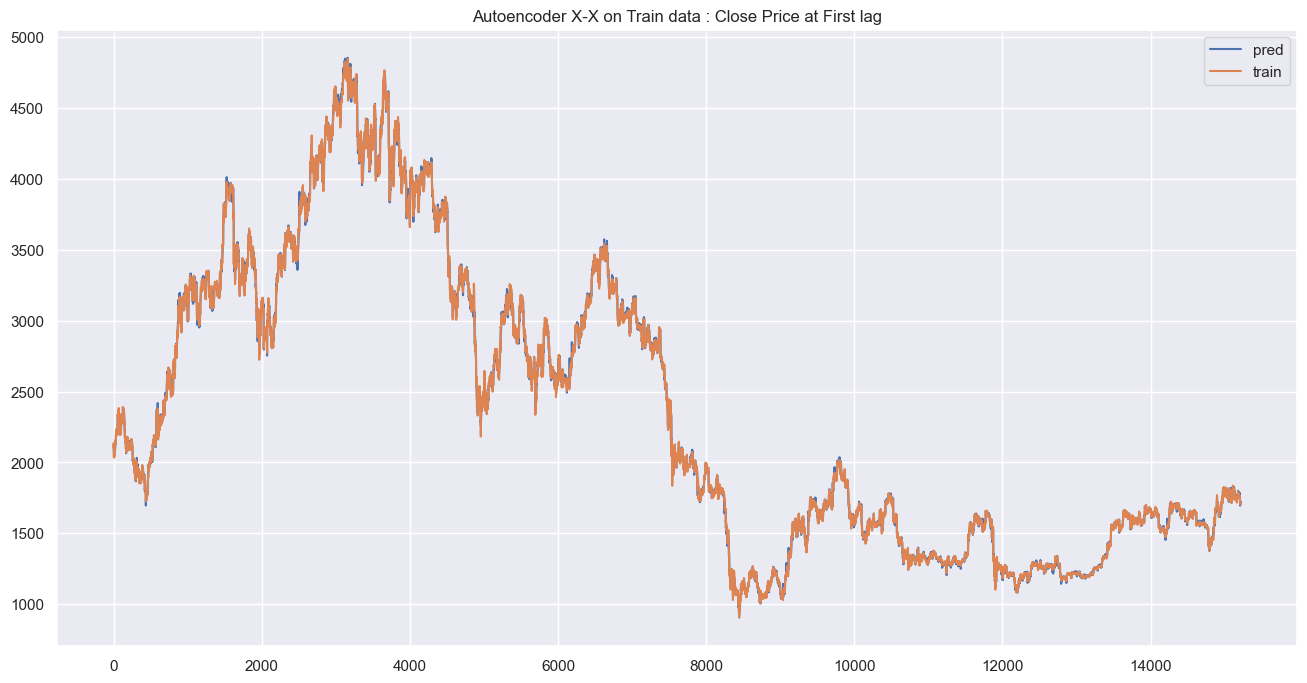

In [69]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [70]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

3/3 [==============================] - 0s 66ms/step


(92, 48, 104)

In [71]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-03-30 14:00:00'

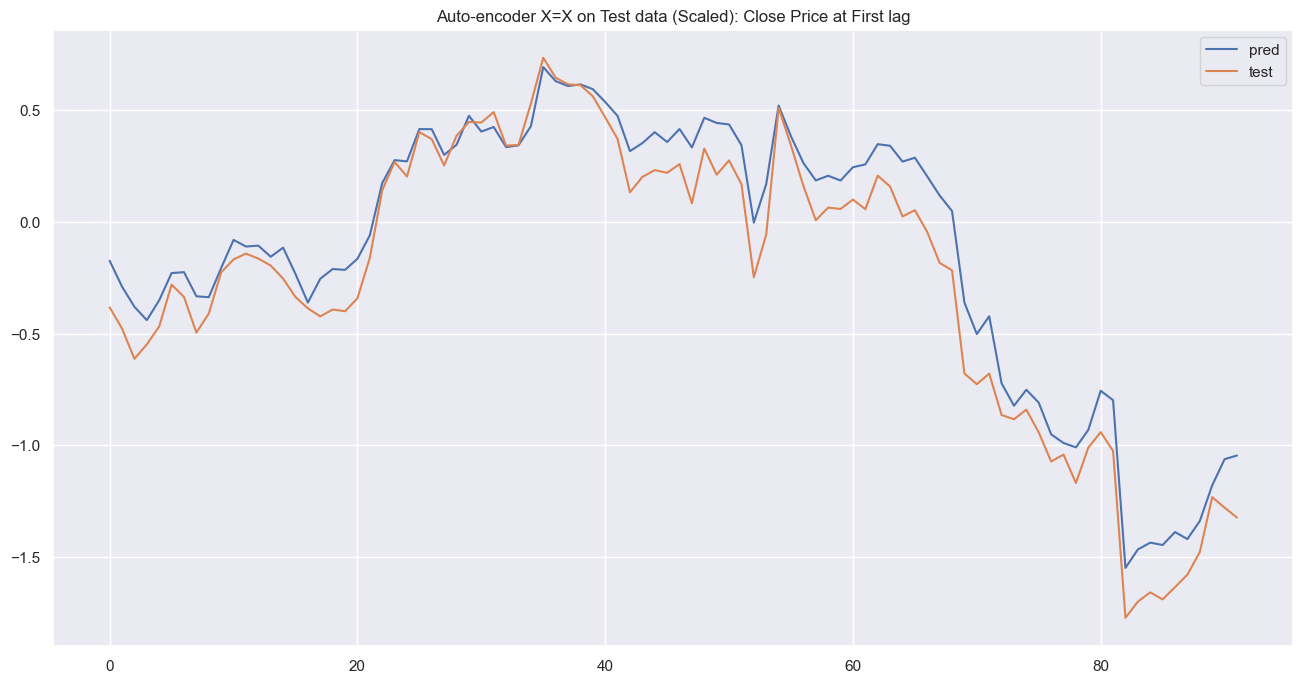

In [72]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [73]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47 1793.61]
X test pred :  [1805.52959743 1800.05856229 1788.12280209 1784.997495   1790.66380801
 1799.21223819 1801.36907517 1797.05345178 1799.28652227]


[1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47 1793.61
 1805.43 1802.35 1803.18 1803.22 1804.71 1796.62 1797.95 1795.23 1790.
 1790.16 1792.89 1792.89 1807.08 1826.3  1836.73 1830.6  1830.33 1825.53
 1822.95 1829.22 1817.7  1824.26 1826.34 1821.52 1822.85 1833.43 1829.25
 1825.99 1826.92 1825.58 1823.06 1823.46 1825.26 1824.48 1826.95 1824.04
 1826.68 1825.28 1816.86 1820.38 1815.34 1816.83 1815.59 1814.76 1816.63
 1820.7  1823.28 1820.79 1813.19 1811.99 1813.77 1817.68 1814.09 1821.87
 1823.09 1820.6  1818.34 1821.72 1817.17 1817.42 1813.3  1813.93 1812.84
 1797.54 1795.2  1801.52 1797.7  1781.75 1788.38 1786.95 1793.41 1794.51
 1791.09 1771.89 1775.23 1778.34 1777.29 1778.47 1785.87 1794.87 1812.19
 1809.36 1804.17]
[1805.52959743 1800.05856229 1788.12280209 1784.997495   1790.66380801
 1799.21223819 1801.36907517 1797.05345178 1799.28652227 1806.96055248
 1809.09051633 1805.61630976 1807.68583514 1807.75195684 1807.31339007
 1805.92805545 1797.23075157 1803.0225432

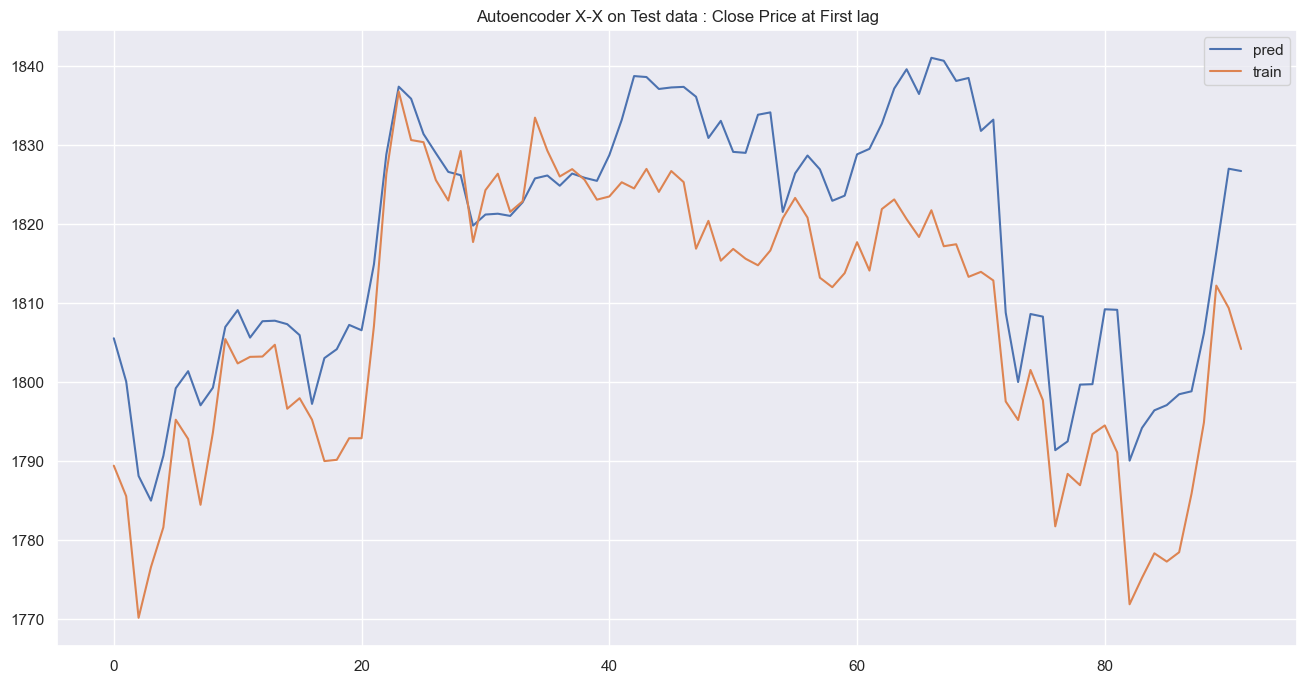

In [74]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [75]:
encoder_model.layers[3].get_weights()

[array([[-0.03471546,  0.31901768,  0.32574174, ...,  0.45168892,
         -0.4619293 , -0.0836118 ],
        [ 0.63057685,  0.38123593, -0.42412302, ..., -0.07473955,
          0.17623706,  0.19691077],
        [ 0.23635717,  0.0403801 ,  0.27963722, ...,  0.1123834 ,
         -0.30647954, -0.16979831],
        ...,
        [-0.18474953, -0.19727504, -0.00778894, ...,  0.0560153 ,
          0.09506679, -0.17280969],
        [-0.00555056,  0.26214316,  0.23717834, ..., -0.32362694,
          0.24982533, -0.29874235],
        [-0.07563527, -0.05258707, -0.04263939, ...,  0.080811  ,
         -0.04566272, -0.19344942]], dtype=float32),
 array([ 0.05760636, -0.01293906, -0.19843519, -0.11801648,  0.2619758 ,
         0.19531131,  0.07574461,  0.05014274, -0.12640406, -0.01852014,
         0.11038674,  0.07549862, -0.13490735,  0.45193136, -0.18190138,
        -0.15974542], dtype=float32)]

## Prediction Models

### LSTM all features

In [78]:
X_train_sca.shape[-1]

15

In [79]:
X_train_sca.shape[-2:]

(72, 15)

In [80]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 20
dropout_rate = 0.01
n_units = 140
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:]))
multi_step_model_1.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-04 08:23:30.308745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-04 08:23:30.309621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-05-04 08:23:31.483512: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-04 08:23:32.158036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-04 08:23:32.318708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-04 08:23:34.707156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1092/1092 [==============================] - ETA: 0s - loss: 0.9992

2023-05-04 08:23:57.421455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-04 08:23:57.510700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1092/1092 [==============================] - 26s 20ms/step - loss: 0.9992 - val_loss: 0.4289
Epoch 2/100
1092/1092 [==============================] - 22s 20ms/step - loss: 0.9899 - val_loss: 0.4089
Epoch 3/100
1092/1092 [==============================] - 23s 21ms/step - loss: 0.9749 - val_loss: 0.4218
Epoch 4/100
1092/1092 [==============================] - 22s 20ms/step - loss: 0.9595 - val_loss: 0.4493
Epoch 5/100
1092/1092 [==============================] - 23s 21ms/step - loss: 0.9488 - val_loss: 0.4212
Epoch 6/100
1092/1092 [==============================] - 23s 21ms/step - loss: 0.9142 - val_loss: 0.3959
Epoch 7/100
1092/1092 [==============================] - 22s 21ms/step - loss: 0.8888 - val_loss: 0.4942
Epoch 8/100
1092/1092 [==============================] - 23s 21ms/step - loss: 0.8740 - val_loss: 0.4352
Epoch 9/100
1092/1092 [==============================] - 22s 21ms/step - loss: 0.8356 - val_loss: 0.4528
Epoch 10/100
1092/1092 [==============================] - 23s 21ms/

0.39587122201919556

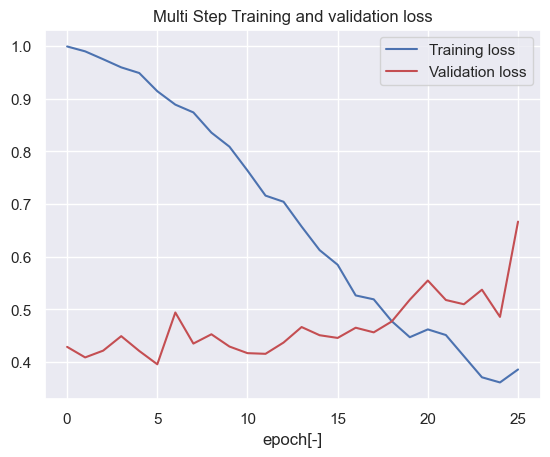

In [85]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss', "data")

#### Save

In [84]:
multi_step_model_1.save(path_mdl_predict_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


#### Results

In [86]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

   1/1092 [..............................] - ETA: 5:39

2023-05-04 08:34:51.069752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-04 08:34:51.124299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 2s

2023-05-04 08:35:03.731165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-04 08:35:03.790082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 23ms/step


In [87]:
y_train_pred_raw_1.shape

(34944, 15)

In [88]:
y_train_raw.shape

(34944, 15)

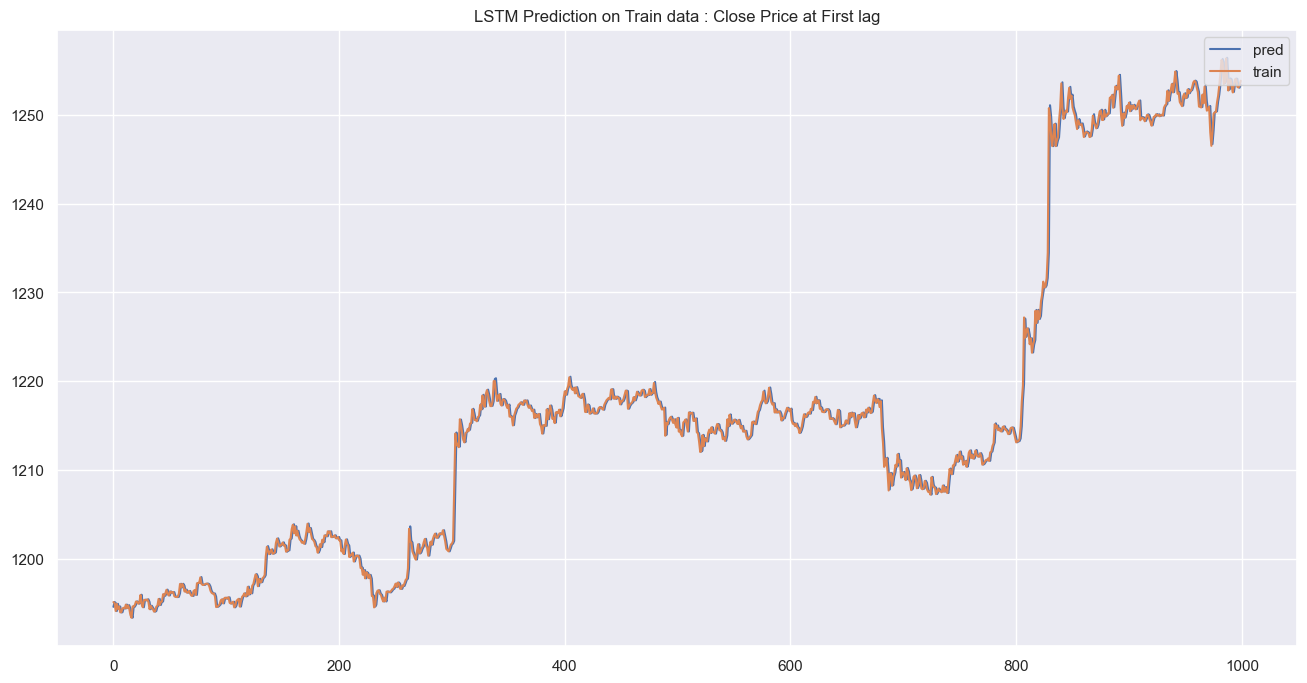

In [89]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

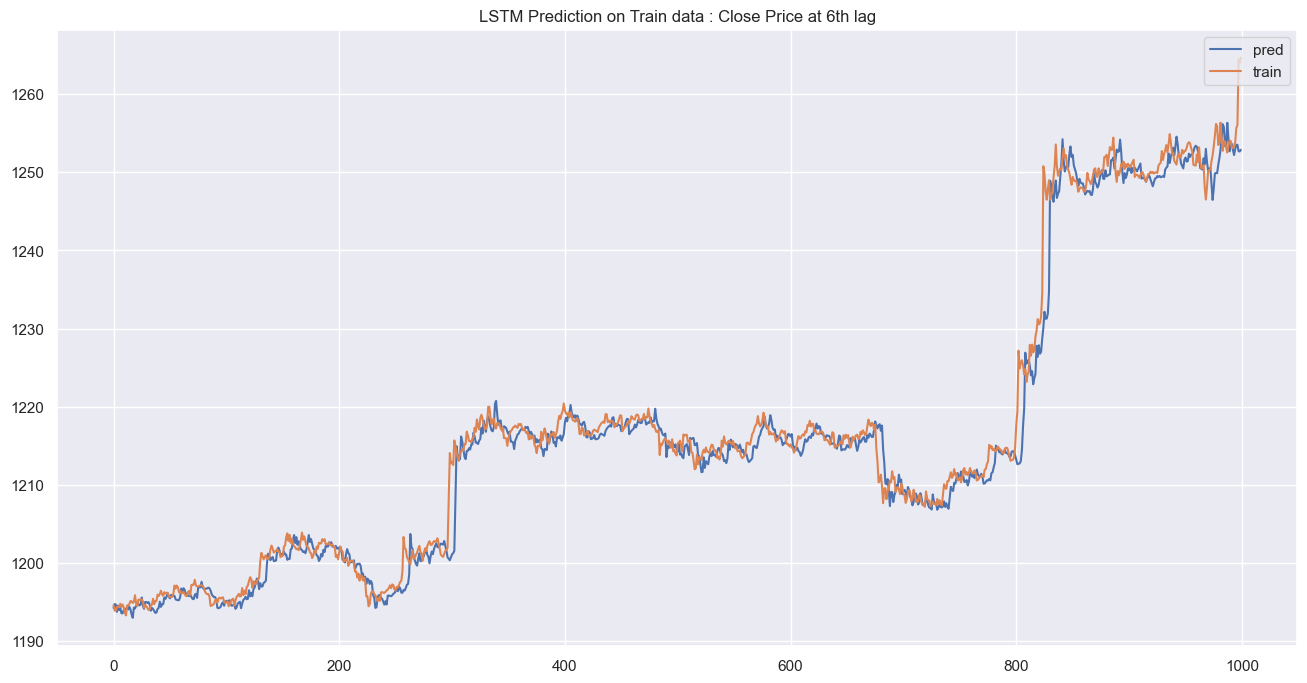

In [90]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

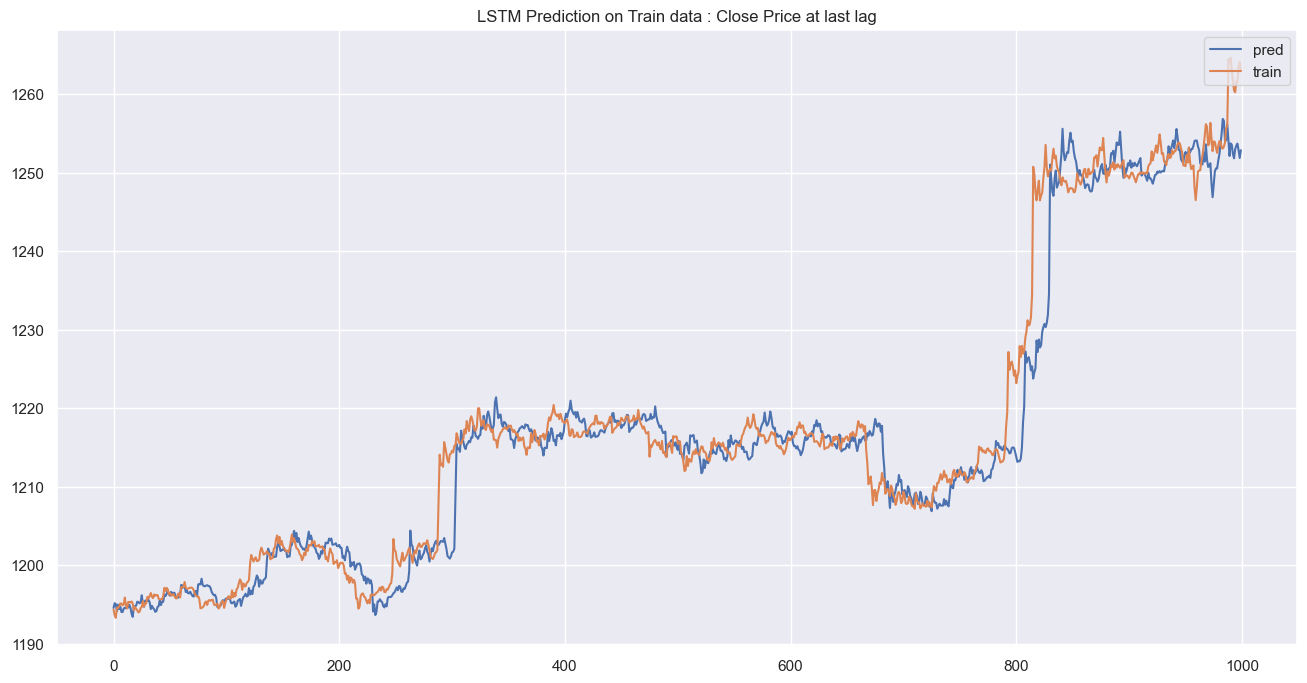

In [91]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

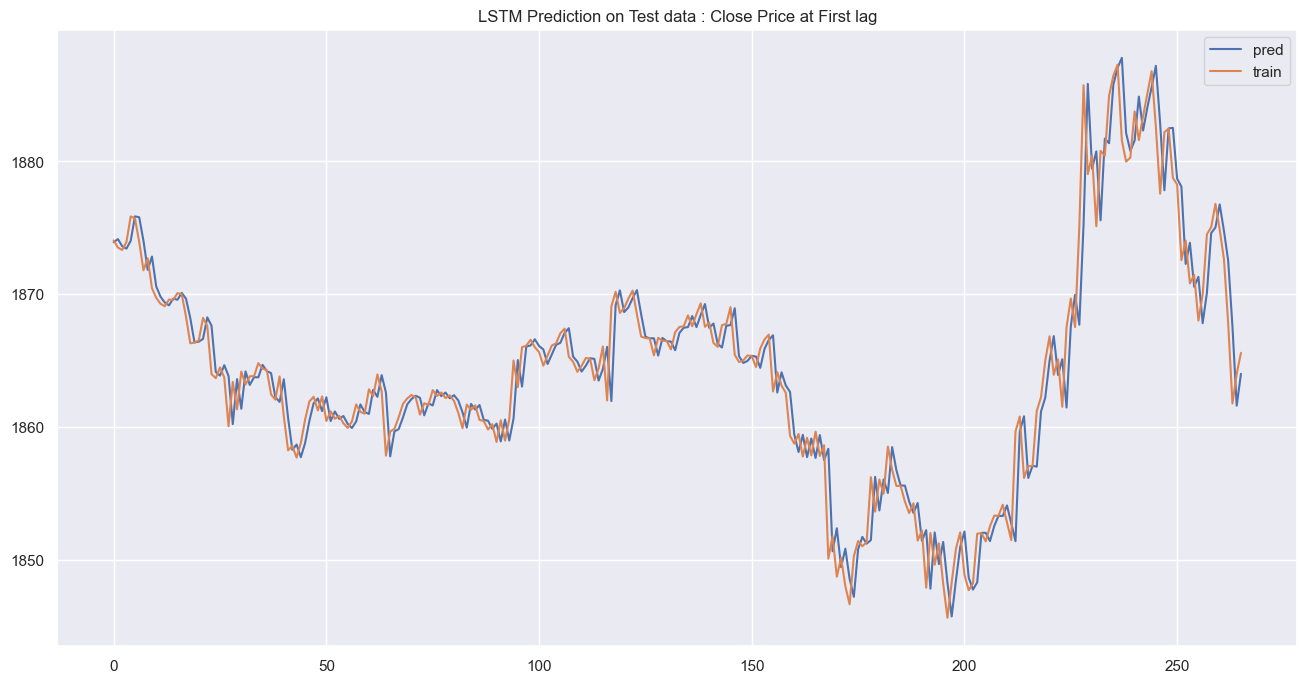

In [92]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

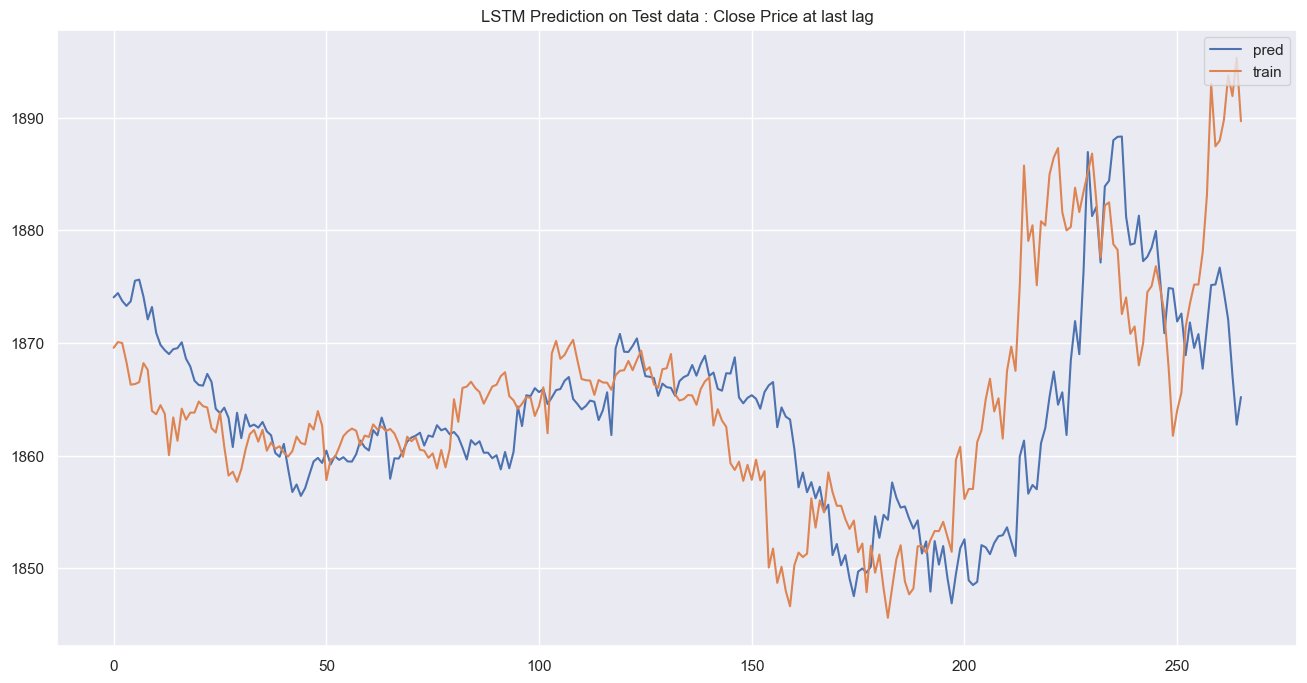

In [93]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [94]:
y_train_pred_unscaled_1[0,:]

array([1.0000145 , 1.000004  , 0.9997744 , 0.9998144 , 0.99970543,
       0.99977815, 0.9998402 , 0.99998826, 1.0000583 , 0.99989843,
       0.9998479 , 0.99980295, 1.0000012 , 1.0000309 , 1.0000308 ],
      dtype=float32)

In [95]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([1194.5574, 1194.5449, 1194.2705, 1194.3184, 1194.1881, 1194.275 ,
       1194.3491, 1194.526 , 1194.6096, 1194.4187, 1194.3583, 1194.3047,
       1194.5415, 1194.5769, 1194.5768], dtype=float32)

In [96]:
y_train_pred_raw_1[0,:]

array([1194.55737283, 1194.54484161, 1194.2705075 , 1194.31828279,
       1194.18812895, 1194.27499311, 1194.34911245, 1194.52597357,
       1194.60963373, 1194.41867497, 1194.35829726, 1194.30461236,
       1194.541424  , 1194.57688167, 1194.57673927])

### Autoencoder + LSTM reduced features

In [74]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

In [76]:
X_train[:,:,0:4].shape

(15218, 48, 4)

In [77]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [76]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

476/476 [==============================] - 5s 9ms/step


(15219, 48, 16)

In [77]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

3/3 [==============================] - 0s 35ms/step


(92, 48, 16)

In [78]:
# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)

In [79]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((15219, 48, 20), (92, 48, 20))

Train

In [86]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 20
dropout_rate = 0.01
n_units = 140
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(
    n_units,
    return_sequences=False,
    input_shape=X_train_.shape[-2:],
    )
)
multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.LayerNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_, y_test_sca), 
    verbose=1, 
    callbacks=[es]
)
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/100
476/476 [==============================] - 12s 23ms/step - loss: 1.0236 - val_loss: 0.3980
Epoch 2/100
476/476 [==============================] - 10s 21ms/step - loss: 0.8041 - val_loss: 0.2401
Epoch 3/100
476/476 [==============================] - 10s 22ms/step - loss: 0.5863 - val_loss: 0.3222
Epoch 4/100
476/476 [==============================] - 10s 22ms/step - loss: 0.4019 - val_loss: 0.3658
Epoch 5/100
476/476 [==============================] - 10s 22ms/step - loss: 0.2963 - val_loss: 0.2155
Epoch 6/100
476/476 [==============================] - 10s 22ms/step - loss: 0.2384 - val_loss: 0.2973
Epoch 7/100
476/476 [==============================] - 10s 22ms/step - loss: 0.2069 - val_loss: 0.3133
Epoch 8/100
476/476 [==============================] - 10s 22ms/step - loss: 0.1880 - val_loss: 0.3654
Epoch 9/100
476/476 [==============================] - 11s 23ms/step - loss: 0.1833 - val_loss: 0.3760
Epoch 10/100
476/476 [==============================] - 10s 22ms/step - l

0.21553976833820343

### Results

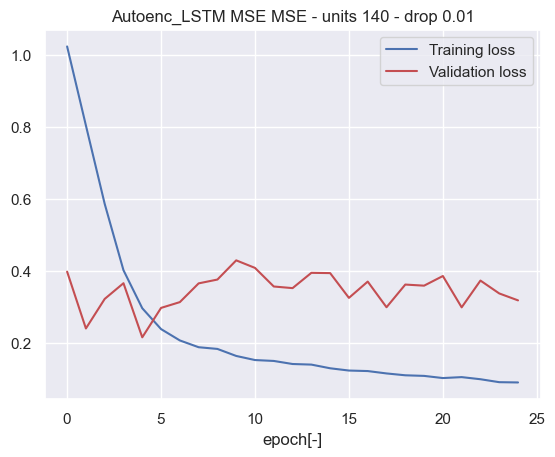

In [87]:
plot_train_history(
    multi_step_history,
    f"Autoenc_LSTM MSE MSE - units {n_units} - drop {dropout_rate}",
    saveFolder="data",
)

Save mdl

In [88]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Predict

In [89]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

3/3 [==============================] - 0s 33ms/step


Plots

In [88]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].shape

(1171, 13)

In [89]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].ravel().shape

(15223,)

In [90]:
np.array(range(y_train_raw.shape[0])).shape

(15218,)

In [91]:
df_feat["Close_ETH"]

0        2106.41
1        2135.18
2        2087.34
3        2094.46
4        2041.20
          ...   
15427    1900.13
15428    1909.19
15429    1905.75
15430    1911.32
15431    1910.38
Name: Close_ETH, Length: 15432, dtype: float64

In [92]:
y_test_raw

array([[1816.86, 1820.38, 1815.34, ..., 1813.19, 1811.99, 1813.77],
       [1820.38, 1815.34, 1816.83, ..., 1811.99, 1813.77, 1817.68],
       [1815.34, 1816.83, 1815.59, ..., 1813.77, 1817.68, 1814.09],
       ...,
       [1909.96, 1911.  , 1909.3 , ..., 1898.14, 1900.13, 1909.19],
       [1911.  , 1909.3 , 1913.87, ..., 1900.13, 1909.19, 1905.75],
       [1909.3 , 1913.87, 1914.56, ..., 1909.19, 1905.75, 1911.32]])

In [93]:
y_train_raw[0::FUTURE_TARGET,:].ravel()[-100:]

array([1752.59, 1749.57, 1749.12, 1753.24, 1751.91, 1752.55, 1774.75,
       1774.99, 1771.43, 1777.76, 1775.57, 1796.47, 1763.63, 1762.81,
       1756.8 , 1766.97, 1765.99, 1765.82, 1760.35, 1764.12, 1776.08,
       1773.88, 1778.87, 1763.31, 1765.53, 1765.  , 1764.63, 1750.3 ,
       1753.44, 1752.2 , 1756.2 , 1763.38, 1764.96, 1765.42, 1756.1 ,
       1754.93, 1719.75, 1711.74, 1717.42, 1707.92, 1714.52, 1704.58,
       1707.74, 1713.01, 1709.49, 1715.22, 1707.56, 1717.02, 1713.72,
       1711.65, 1718.16, 1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 ,
       1717.58, 1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31,
       1736.42, 1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99,
       1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
       1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83, 1810.18,
       1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02, 1803.47,
       1794.61, 1790.52, 1793.07, 1785.26, 1791.09, 1816.8 , 1787.66,
       1796.82, 1797

In [94]:
y_train_raw[0::FUTURE_TARGET,:].ravel()

array([2226.99, 2206.73, 2196.48, ..., 1787.66, 1796.82, 1797.13])

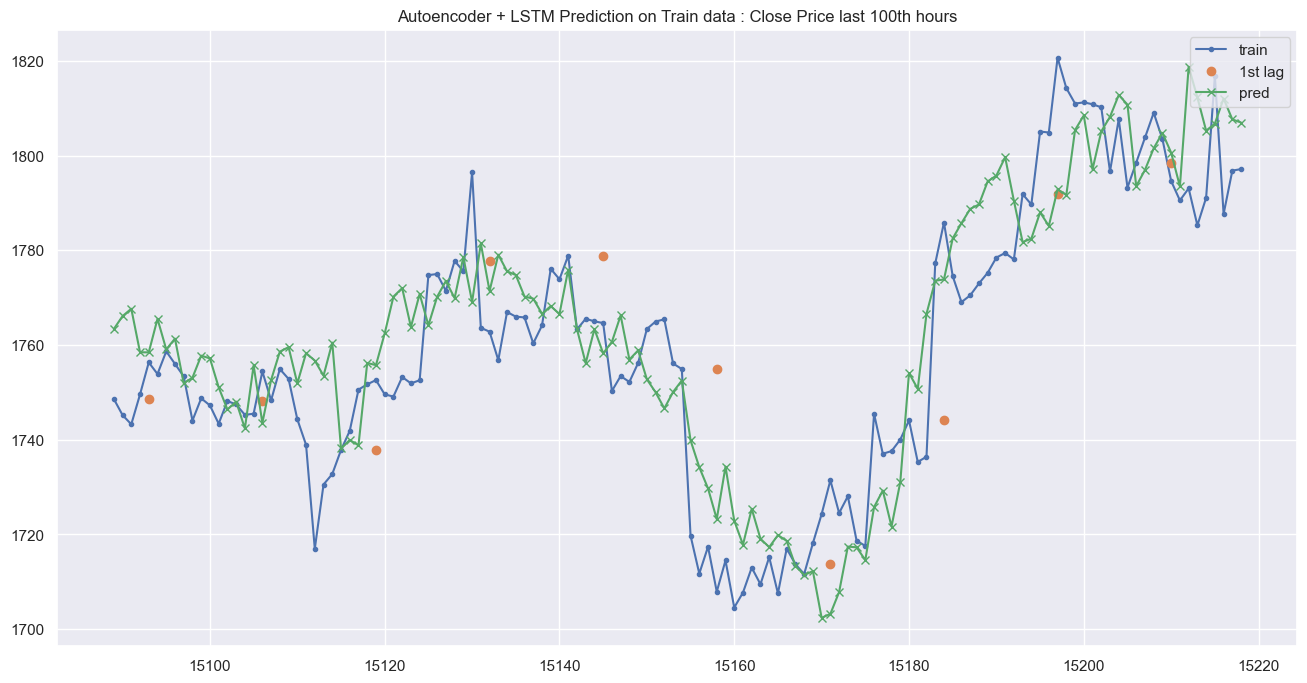

In [90]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price last 100th hours")
nb_pred = 10
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_train_raw.shape[0], FUTURE_TARGET))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [107]:
y_test_raw.shape

(91, 13)

In [108]:
y_test_raw.shape[0]

91

In [109]:
y_test_raw[0::FUTURE_TARGET,:].ravel().shape

(91,)

In [111]:
np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET)).shape

(7,)

In [112]:
y_test.shape

(91, 13)

In [113]:
y_test_raw.shape

(91, 13)

In [114]:
x_axis_1

array([    0,    13,    26, ..., 15041, 15054, 15067])

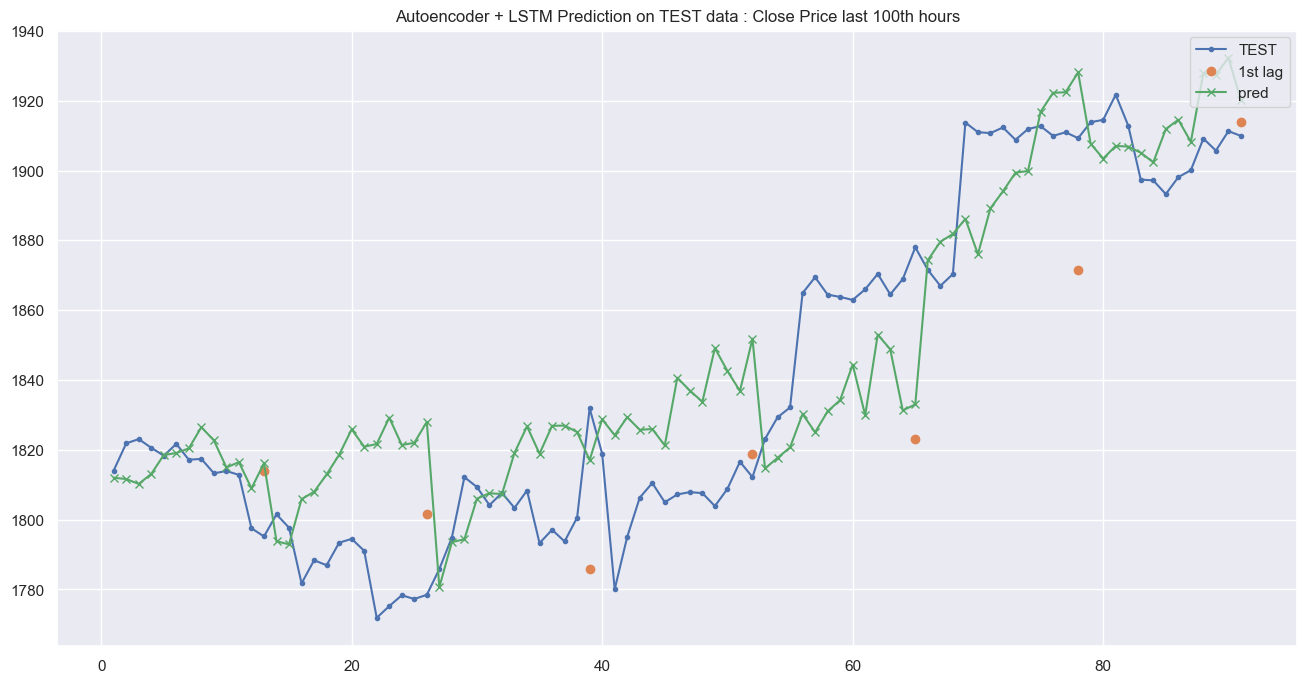

In [91]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
nb_pred = 7
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="TEST")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [261]:
np.array(range(0,y_test_raw.shape[0], FUTURE_TARGET))

array([ 0, 13, 26, 39, 52, 65, 78])

In [262]:
y_test_raw[range(0,y_test_raw.shape[0], FUTURE_TARGET),:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [263]:
y_test_raw[:,0]

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [264]:
y_test_raw[0::FUTURE_TARGET,:].ravel()

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [253]:
y_test_raw[0::FUTURE_TARGET,:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [251]:
y_test_raw[-13:, :]

array([[1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01],
       [1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63,
        1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 1789.42],
       [1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53,
        1804.62, 1804.21, 1797.69, 1795.01, 1789.42, 1785.56],
       [1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62,
        1804.21, 1797.69, 1795.01, 1789.42, 1785.56, 1770.18],
       [1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21,
        1797.69, 1795.01, 1789.42, 1785.56, 1770.18, 1776.6 ],
       [1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69,
        1795.01, 1789.42, 1785.56, 1770.18, 1776.6 , 1781.62],
       [1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01,
        1789.42, 1785.56, 1770.18, 1776.6 , 1781.62, 1795.23],
       [1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 

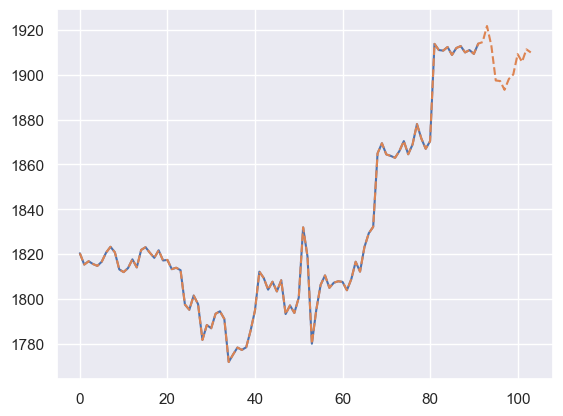

In [92]:
plt.plot(y_test_raw[:,0])
plt.plot(y_test_raw[0::FUTURE_TARGET,:].ravel(),'--')

In [98]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1909.96 1911.   1909.3  1913.87 1914.56 1921.74 1912.9  1897.45 1897.2
 1893.28 1898.14 1900.13 1909.19]
[1914.24346493 1914.28906893 1923.18595144 1922.22461932 1926.32419005
 1929.39174248 1931.88514066 1936.71323514 1941.02076007 1939.73814783
 1939.11656544 1938.73805232 1946.12407463]


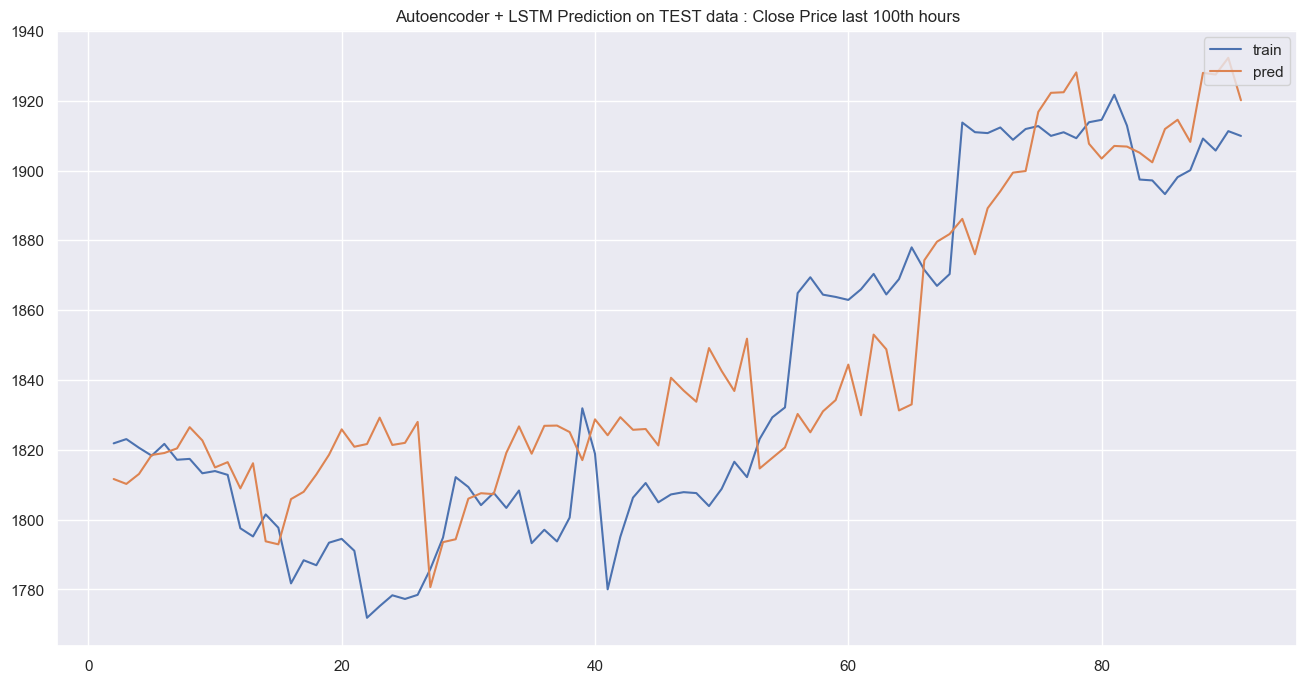

In [93]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
x_axis = np.array(range(y_test_raw.shape[0]))
plt.plot(x_axis[-90:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="train")
plt.plot(x_axis[-90:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="pred")
plt.legend(loc='upper right')

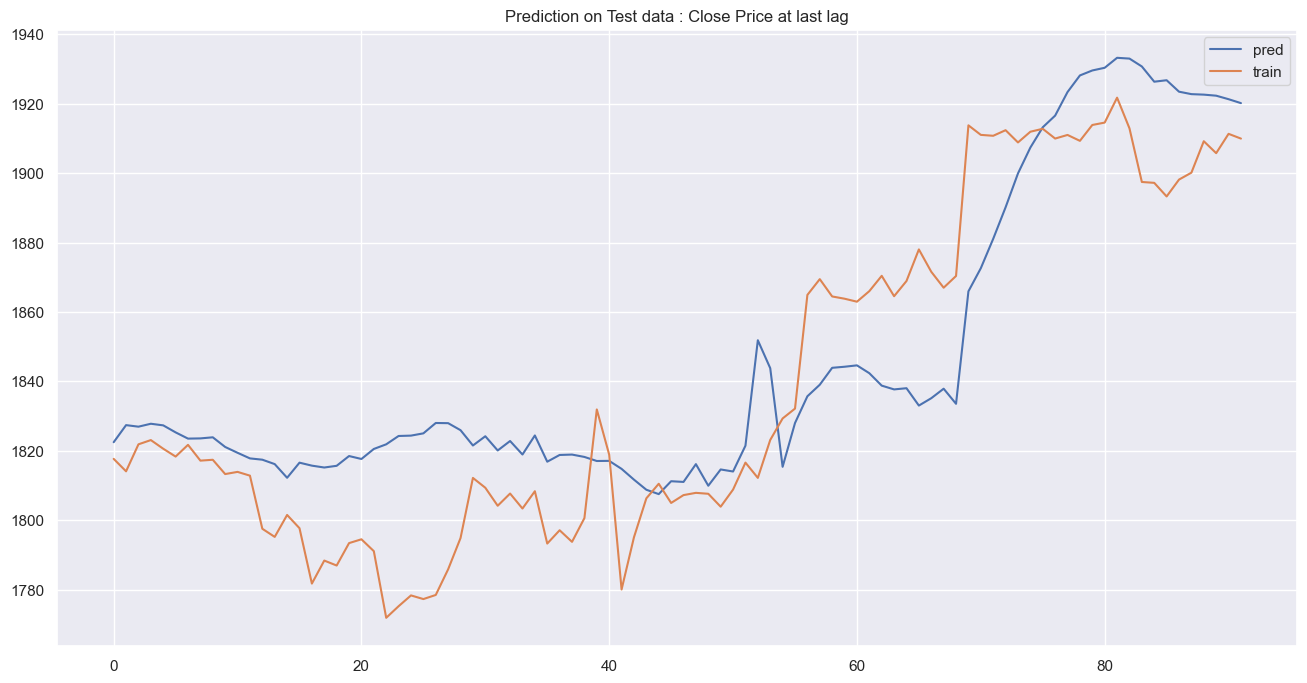

In [94]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

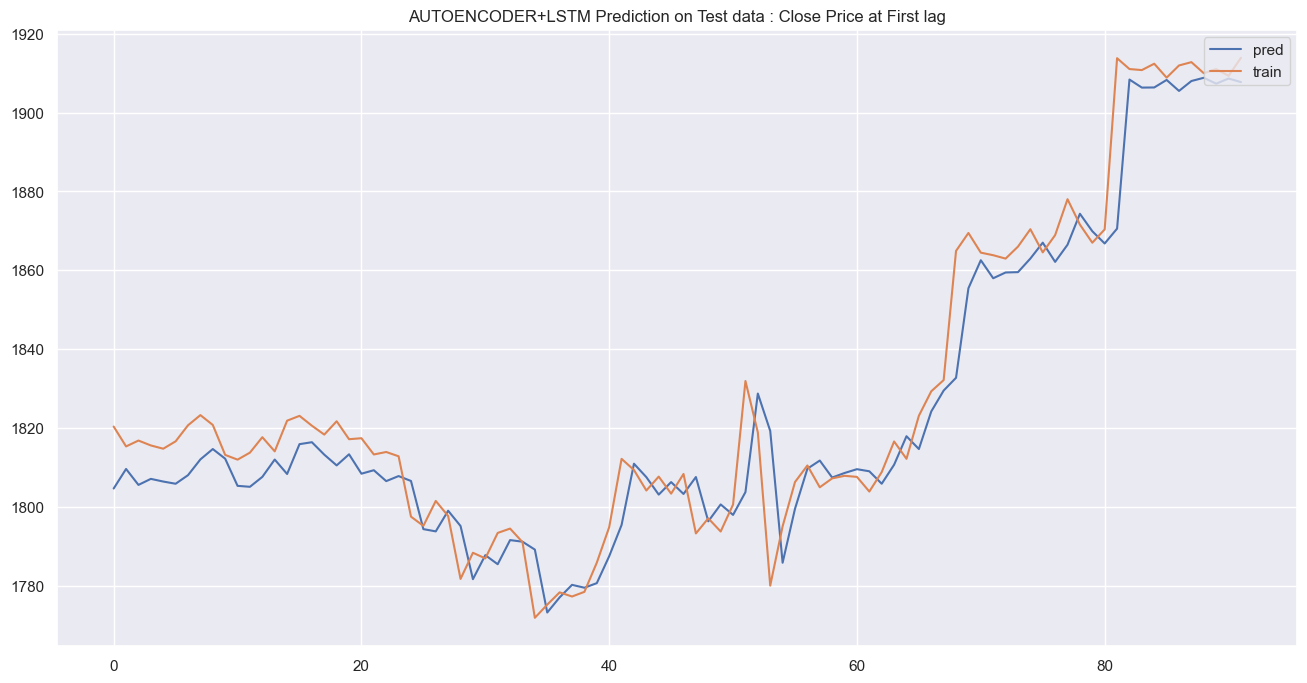

In [95]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

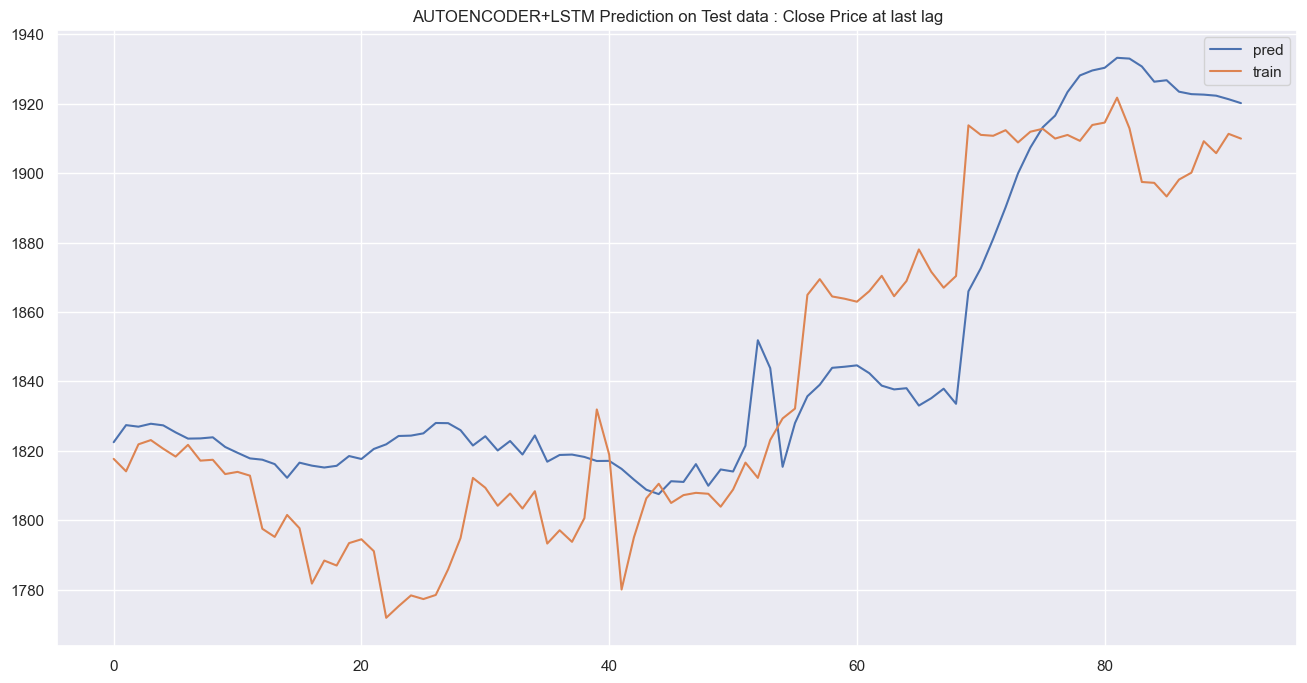

In [96]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [125]:
str(time.time())

'1680725792.947519'

## Predict last prediction

In [146]:
X_test_sca.shape

(266, 72, 15)

In [127]:
df_feat["Close_ETH"].iloc[-1]

1802.65

In [140]:
df_feat["Close_ETH"].iloc[-1]

1802.65

In [97]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale py ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate
X_last_ = np.concatenate([X_last_sca[:,:,0:4], X_last_encoded_sca], axis=-1)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))

[batch, lags, features]
X_last[0,:,0]:
[1804.98 1807.24 1807.89 1807.62 1803.9  1808.83 1816.6  1812.2  1823.12
 1829.32 1832.16 1864.91 1869.46 1864.47 1863.82 1862.96 1866.   1870.41
 1864.54 1868.92 1878.02 1871.58 1866.99 1870.37 1913.77 1911.02 1910.76
 1912.37 1908.84 1911.93 1912.77 1909.96 1911.   1909.3  1913.87 1914.56
 1921.74 1912.9  1897.45 1897.2  1893.28 1898.14 1900.13 1909.19 1905.75
 1911.32 1909.95 1909.66]
X_last[0,:,0] after divide by price:
[0.94518396 0.94636742 0.94670779 0.9465664  0.94461841 0.94720003
 0.95126881 0.94896474 0.95468303 0.95792968 0.95941686 0.97656651
 0.97894913 0.9763361  0.97599573 0.97554539 0.97713729 0.9794466
 0.97637276 0.97866636 0.98343161 0.98005928 0.97765571 0.97942566
 1.00215222 1.00071217 1.00057602 1.0014191  0.9995706  1.00118869
 1.00162856 1.0001571  1.0007017  0.99981148 1.00220458 1.0025659
 1.00632573 1.00169664 0.99360619 0.99347528 0.99142256 0.99396751
 0.99500958 0.99975388 0.99795252 1.00086926 1.00015186 1.        

In [98]:
PAST_HISTORY

72

In [147]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35417,1683156300000,1907.21,1908.40,1903.89,1904.11,1142.7050,2023-05-03 23:25:00,29086.08,29107.93,29043.70,29043.70,76.97644,2023-05-03 23:25:00,326.2,326.5,325.7,325.9,1605.372,2023-05-03 23:25:00,False
35418,1683156600000,1904.11,1906.39,1902.71,1903.66,839.1494,2023-05-03 23:30:00,29043.70,29074.56,29025.00,29029.98,171.08664,2023-05-03 23:30:00,325.9,326.4,325.8,325.8,1800.158,2023-05-03 23:30:00,False
35419,1683156900000,1903.66,1904.76,1899.57,1900.97,1510.2727,2023-05-03 23:35:00,29029.98,29051.82,28984.41,28990.80,259.24123,2023-05-03 23:35:00,325.9,326.1,325.6,325.6,1155.657,2023-05-03 23:35:00,False
35420,1683157200000,1900.97,1902.40,1898.73,1899.38,1319.6997,2023-05-03 23:40:00,28990.56,29022.13,28945.39,28946.24,230.84357,2023-05-03 23:40:00,325.7,325.8,325.4,325.6,1477.636,2023-05-03 23:40:00,False


In [148]:
mode_lstm_simple = True
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

1/1 [==============================] - 0s 118ms/step
[[1903.2333 1902.593  1902.5985 1902.6066 1902.7266 1902.6089 1902.1858
  1902.6595 1902.5143 1902.1666 1902.0294 1902.2198 1902.384  1902.3137
  1902.2065]]
[1902.6066, 1902.7266, 1902.6089, 1902.1858, 1902.6595, 1902.5143, 1902.1666, 1902.0294, 1902.2198, 1902.384, 1902.3137, 1902.2065]


In [102]:
y_last_pred_unscaled

array([[0.9998826 , 0.9995854 , 0.99957967, 0.9995649 , 0.9996004 ,
        0.9995141 , 0.9993031 , 0.99963456, 0.9994834 , 0.99929523,
        0.9991355 , 0.9992443 , 0.9993113 , 0.99937654, 0.9992815 ]],
      dtype=float32)

In [101]:
df_feat["Close_ETH"].iloc[-1]

1897.92

In [100]:
y_last_pred_raw

array([[1897.6971, 1897.1332, 1897.1223, 1897.0942, 1897.1616, 1896.9978,
        1896.5974, 1897.2264, 1896.9396, 1896.5824, 1896.2793, 1896.4857,
        1896.613 , 1896.7368, 1896.5564]], dtype=float32)

In [103]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [149]:
save_list(list_pred, path_save_pred_vals)

In [150]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [151]:
list_pred_reload

[1902.6066,
 1902.7266,
 1902.6089,
 1902.1858,
 1902.6595,
 1902.5143,
 1902.1666,
 1902.0294,
 1902.2198,
 1902.384,
 1902.3137,
 1902.2065]